<a href="https://colab.research.google.com/github/haribharadwaj/notebooks/blob/main/CSD2045/Generate_Tymp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook uses a simplified Vanhuyse-style model to generate typical tympanometric admittance curves

For more details see:
Vanhuyse, V. J., Creten, W. U., & Van Camp, K. J. (1975). On the W-notching of tympanograms. Scandinavian Audiology, 4(1), 45-50.

Here only 4 parameters are exposed.

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(1, 0.0, '0.0'),
  Text(1, 0.2, '0.2'),
  Text(1, 0.4, '0.4'),
  Text(1, 0.6000000000000001, '0.6'),
  Text(1, 0.8, '0.8'),
  Text(1, 1.0, '1.0')])

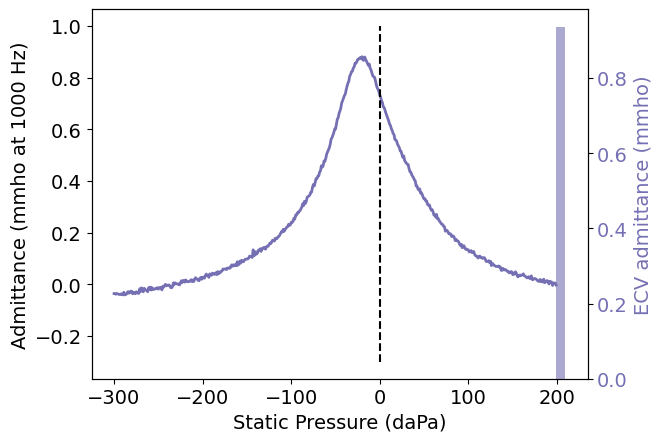

In [2]:
#@title This section generates tymps with preset parameters
import numpy as np
import pylab as pl

def vanhuyse_model(p, tpp=-10, G=0, Q=0.02):
    """
    Calculate the admittance based on the Vanhuyse model for tympanograms.

    Parameters:
    - p: Static air pressure in the ear canal (daPa).
    - tpp: Tympanometric peak pressure (daPa).
    - G: Conductance term.
    - Q: Quality factor related to the sharpness of the resonance peak.

    Returns:
    - Admittance (Y) as a complex number
    """
    # Convert to complex for calculation
    j = 1j

    # Calculate the admittance using the Vanhuyse model
    Y = 1 / (1 + j * (2 * Q) * (p - tpp)) + G / (1 + j * (2 * Q) * (p + tpp))
    return Y

def getTympanogram(p, tpp=-10, G=0, Q=0.02):
    Y = vanhuyse_model(p, tpp, G, Q)
    tymp = abs(Y) - abs(Y)[-1]
    N = p.shape[0]
    n = generate_gaussian_noise(N, sigma=0.005, T=N/4)
    # Add a hint of noise

    return tymp + n

import numpy as np

def generate_gaussian_noise(N, sigma=0.005, T=20):
    """
    Generate N samples of Gaussian stationary noise with an exponential autocorrelation function.

    Parameters:
    - N: The number of samples.
    - sigma: The standard deviation of the noise.
    - T: The characteristic scale for the exponential decay of the autocorrelation.

    Returns:
    - noise: N samples of the generated noise.
    """
    # Time steps, assuming unit sampling interval
    x = np.arange(N)

    # Autocorrelation function in time domain
    R_tau = sigma**2 * np.exp(-np.abs(x) / T)

    # Power Spectral Density (PSD) via Fourier Transform of the autocorrelation function
    PSD = np.fft.fft(R_tau, n=2*N-1)

    # Ensure PSD is real-valued due to numerical issues
    PSD = np.real(PSD)

    # Generate Gaussian white noise in frequency domain
    random_phase = np.exp(2j * np.pi * np.random.rand(2*N-1))
    sqrt_PSD = np.sqrt(PSD)
    noise_freq = sqrt_PSD * random_phase

    # Inverse Fourier Transform to get the noise in time domain
    noise = np.fft.ifft(noise_freq)[:N]

    # Ensure the noise is real
    # (it should be theoretically, but may not be due to numerical issues)
    noise = np.real(noise)

    # Scale the noise to have the desired standard deviation
    noise = noise * sigma / np.std(noise)

    return noise


# Example usage
p = np.arange(-300, 200)  # Example pressures in daPa
tpp = -20  # Example tympanometric peak pressure in daPa
G = 0.1  # Example conductance
Q = 0.015  # Example quality factor
tymp = getTympanogram(p, tpp, G, Q)
ymax = np.max([np.max(tymp), 1])
ymin = np.min([np.min(tymp), -0.3])
lcol = [117./255, 112./255, 179./255]
rcol = [217./255, 95./255, 2./255]

pl.plot(p, tymp, color=lcol, linewidth=2)
pl.vlines(x=0, ymin=ymin, ymax=ymax, colors='k', linestyles='dashed')
pl.xlabel('Static Pressure (daPa)', fontsize=14)
pl.ylabel('Admittance (mmho at 1000 Hz)', fontsize=14)
pl.xticks(fontsize=14)
pl.yticks(fontsize=14)

# Bar plot
ecy = np.random.randn()*0.1  + 1
ax2 = pl.gca().twinx()
ax2.set_ylabel('ECV admittance (mmho)', color=lcol, fontsize=14)
ax2.bar(np.max(p) + 5, ecy, color=lcol, alpha=0.6, width=10)
ax2.tick_params(axis='y', labelcolor=lcol)


pl.yticks(fontsize=14)
